Import mutation analysis results and clean up dataframe

In [33]:
import pickle
import pandas as pd
import re

with(open('./data/Essential_proteins_mutated.pkl', 'rb')) as f:
    Mutated_proteins = pickle.load(f)

Mutated_df = pd.DataFrame(columns = ['Protein', 'WT_prediction', 'Mut_prediction', 'WT_diff', 'Mut_diff', 'WT_sequence', 'Mut_sequence', 'Mutations'])
for key in Mutated_proteins:
    wt_prediction = Mutated_proteins[key][0][0][0][0]
    mut_prediction = Mutated_proteins[key][0][1][0][0]
    WT_diff = Mutated_proteins[key][2][0]
    Mut_diff = Mutated_proteins[key][2][1]
    wt_seq = ''.join(Mutated_proteins[key][1][0])
    mut_seq = ''.join(Mutated_proteins[key][1][1])
    mutations_list = []
    for i in range(len(wt_seq)):
        if wt_seq[i] != mut_seq[i]:
            mutations_list.append(f'{wt_seq[i]}{i+1}{mut_seq[i]}')
    new_row = [key.split('-')[1], wt_prediction, mut_prediction, WT_diff, Mut_diff, wt_seq, mut_seq, mutations_list]
    #print(new_row)
    Mutated_df.loc[len(Mutated_df)] = new_row
    
    
#Import Essential proteins original dataframe
Ess_prot = pd.read_csv('./data/essential_proteins_final.csv')
Ess_prot['AlphaFoldDB'] = Ess_prot['AlphaFoldDB'].str.replace(';', '', regex=False)


#Merge the two dataframes
Ess_prot_merged = pd.merge(Ess_prot, Mutated_df, left_on='AlphaFoldDB', right_on='Protein', how='left')

#clean up df
Ess_prot_merged['resi_change'] = Ess_prot_merged['Mutations'].apply(lambda x: '+'.join(re.findall(r'\d+', str(x))) if x != [] else None)
Ess_prot_merged.drop(columns=['Protein', 'Sequence', 'WT_diff', 'Mut_diff'], inplace=True, errors='ignore')

#Add Tm Increase
Ess_prot_merged['Temp_diff'] = Ess_prot_merged['Mut_prediction'] - Ess_prot_merged['WT_prediction']
Ess_prot_merged['Mut_number'] = Ess_prot_merged['Mutations'].apply(lambda x: len(x) if isinstance(x, list) else 0)
Ess_prot_merged['rel_Mut_number'] = Ess_prot_merged.apply(lambda row: row['Mut_number'] / len(row['WT_sequence']) if row['Mut_number'] != 0 else 0, axis=1)

#save new df to csv
#Ess_prot_merged.to_csv('./data/Essential_proteins_prediction_merged.csv', index=False)


#### Check distributions

Percentage of rows with 'Temp_diff' 10°C or above: 48.00%


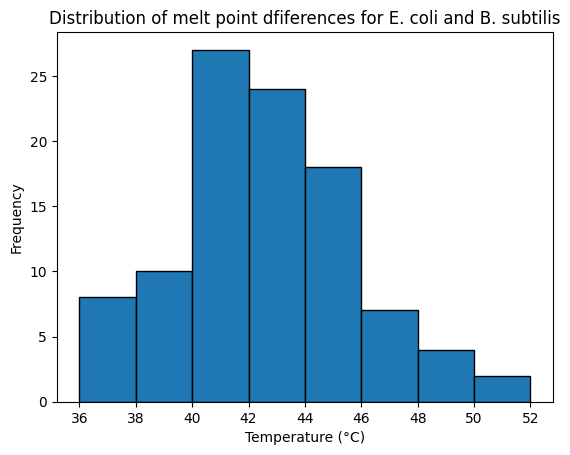

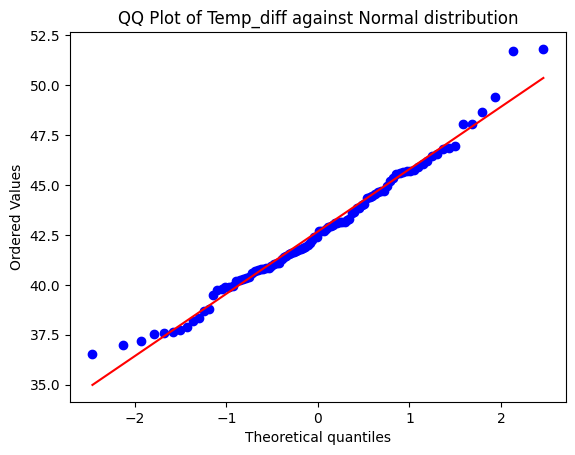

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats


Ess_prot_merged_drop = Ess_prot_merged.dropna(subset=['Temp_diff'])
Ess_prot_merged_drop = Ess_prot_merged_drop[Ess_prot_merged_drop['Temp_diff'] != 0]
organisms_to_keep = ['Bacillus subtilis (strain 168)', 'Escherichia coli (strain K12)']
Ess_prot_merged_filtered = Ess_prot_merged_drop[Ess_prot_merged_drop['Organism'].isin(organisms_to_keep)]

# Filter rows where 'Temp_diff' is 10°C or above
temp_above_10 = Ess_prot_merged_filtered[Ess_prot_merged_filtered['Temp_diff'] >= 10]
# Calculate the percentage
percentage_above_10 = (len(temp_above_10) / len(Ess_prot_merged_filtered)) * 100
print(f"Percentage of rows with 'Temp_diff' 10°C or above: {percentage_above_10:.2f}%")


# Assuming df is your DataFrame and 'Temperature' is the column of interest
# Calculate the range of Temperature values and create bins of size 5°C
min_temp = Ess_prot_merged_filtered['meltPoint_x'].min()
max_temp = Ess_prot_merged_filtered['meltPoint_x'].max()
bins = range(int(min_temp), int(max_temp) + 2, 2)  # +5 to include the max value

# Plot the histogram
plt.hist(Ess_prot_merged_filtered['meltPoint_x'], bins=bins, edgecolor='k')
plt.xlabel('Temperature (°C)')
plt.ylabel('Frequency')
plt.title(f'Distribution of melt point dfiferences for E. coli and B. subtilis')
plt.show()
#plot QQ
stats.probplot(Ess_prot_merged_filtered['meltPoint_x'], dist="norm", plot=plt)
plt.title('QQ Plot of Temp_diff against Normal distribution')

plt.show()

#### Analyse significance and calculate p-Values
(Preets calculation missing)

In [35]:
#pValue calculation
p_values = {
    'meltPoint_WT': {
        'B. subtilis': 0.00001,
        'E. coli': 0.0000072515,
        'P. torridus': 0.8268515232,
        'T. thermophilus': 0.00080533205
    },
    'WT_Mut': {
        'B. subtilis': 0.00001,
        'E. coli': 5.67e-8,
        'P. torridus': 0.7281407841,
        'T. thermophilus': 0.8413022179
    }
}

def p_to_asterisks(p):
    if p < 0.0001:
        return '****'
    elif p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return 'ns'

#### Plot improvements per organism

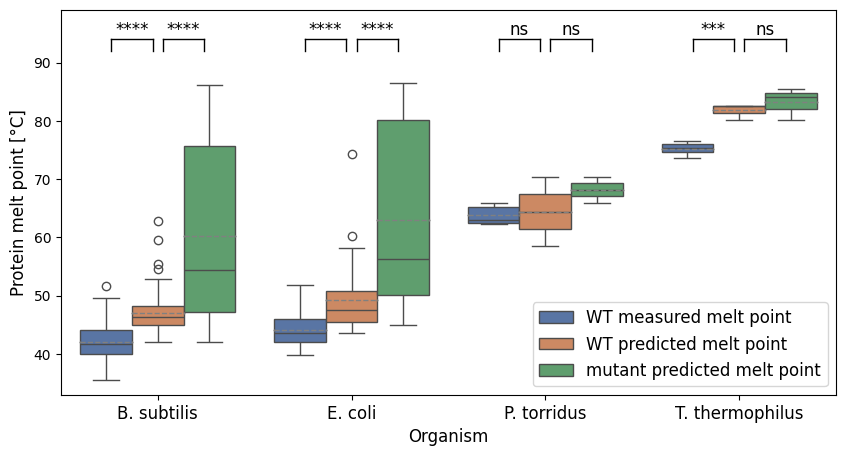

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.patches import FancyArrowPatch 

plt.figure(figsize=(10, 5))

long_df = pd.melt(Ess_prot_merged, id_vars=['Organism'], value_vars=['meltPoint_x','WT_prediction', 'Mut_prediction'], var_name='Prediction_Type', value_name='Temp_Value')

sns.boxplot(data=long_df, x='Organism', y='Temp_Value', hue='Prediction_Type', palette = 'deep', showmeans = True, meanprops={"marker":".","markerfacecolor":"gray", "markeredgecolor":"gray", "markersize":"1", "color":"gray"}, meanline=True)
#sns.stripplot(data=long_df, x='Organism', y='Temp_Value', hue='Prediction_Type', dodge=True, jitter=True, color='black', alpha = 0.8, size = 2)
new_label = ['B. subtilis', 'E. coli', 'P. torridus', 'T. thermophilus']
plt.ylabel('Protein melt point [°C]', size=12)
plt.xticks(ticks=range(len(new_label)), labels=new_label, rotation=0, size=12)
plt.xlabel('Organism', size=12)
legend = plt.legend(title='', fontsize=12)
new_legend_label = ['WT measured melt point', 'WT predicted melt point', 'mutant predicted melt point']
for text, label in zip(legend.texts, new_legend_label):
    text.set_text(label)



#annotate p-values
hue_order = long_df['Prediction_Type'].unique()
n_hues = len(hue_order)
width = 0.8
spacing = width / n_hues


ax = plt.gca()
y_min, y_max = ax.get_ylim()
y_max +=10
plt.ylim(y_min, y_max)

for i, org in enumerate(new_label):
    for j, hue in enumerate(hue_order):
        key = f'{hue_order[j-1].split('_')[0]}_{hue.split('_')[0]}'
        if key in p_values.keys():
            p = p_values[key][org]
            p_asterisks = p_to_asterisks(p)
            x = i + j * spacing - width / 2 
            y = y_max - 5
            line = mlines.Line2D([x-spacing/2.5,x+spacing/2.5],[y,y], color='black', linestyle='-', linewidth=1)
            line_v1 = mlines.Line2D([x-spacing/2.5,x-spacing/2.5], [y-2, y], color='black', linestyle='-', linewidth=1)
            line_v2 = mlines.Line2D([x+spacing/2.5,x+spacing/2.5], [y-2, y], color='black', linestyle='-', linewidth=1)

            plt.gca().add_line(line)    
            plt.gca().add_line(line_v1)
            plt.gca().add_line(line_v2)
            plt.text(x, y, p_asterisks, ha='center', va='bottom', fontsize=12)

plt.savefig('essential_proteins_boxplot.svg', format='svg')
plt.show()

#### Reduce mutations of P094501_gltR
Manually selected as an example, since it has many mutations and a large structural deviation

In [21]:
from ThERMOS import mutation_decreaser
from SPARC import SPARC

protein_to_analyse = 'P94501_gltR'
selected_row = Ess_prot_merged[Ess_prot_merged['Protein_ID'] == protein_to_analyse]
wt = selected_row['WT_sequence'].iloc[0]
mut = selected_row['Mut_sequence'].iloc[0]
wt_temp = selected_row['WT_prediction'].iloc[0]
mut_temp = selected_row['Mut_prediction'].iloc[0]

red_mut = mutation_decreaser(mut_temp, wt_temp, wt, mut, name = protein_to_analyse, cutoff= 0.9)

#Analyse results of mutation_decreaser
red_seq = red_mut[0]
reduced_mut = []
for i in range(len(red_seq)):
    if red_seq[i] != mut[i]:
        reduced_mut.append(i+1)
print(f'Mutations reverted: {reduced_mut}')
print(f'Number of reverted mutations {len(reduced_mut)}')
print(f'New amino acid sequence {red_seq}')

red_mut_list = []
for i in range(len(wt)):
    if wt[i] != red_seq[i]:
        red_mut_list.append(i+1)
        
print(f'Mutation position formatted for resi selection in pymol{'+'.join([str(x) for x in red_mut_list])}')


#Calculate new temperature
wt_pred = 45.76974259982553 # predicted wild type melt point
mut_pred = 84.11407590083442 # predicted original mutant melt point
mP = 44.6681154920215 # measured melt point
#mutant with reverted acive center amino acids, new mutant after reducing the number of mutations and reverting active center amino acids
mut_az = 'MNIQLLQVFLTAAREGSISKAALTLNYAQSNVTNKIQQLENDLETKLFYRHSRGIALTPPGELLVAYSEKILHTIEEARAARGESSARSGPLRLGARETAAAVWLPQLLAHYNNLYPNVDLNLVTGPTEQEIEAVLHYELNGAFIPGPLEHPDLVEEKVLDEEMVLVRPAPHPVLPPLEDVRARRKLVFRKGCNYRARLNHLLREEGLLPLKLMEFGLLEALLGCVNARLGNNLLPRNNNASHEKEARNRYHRNYDKYYFVARMFVRRKDRLVRPARWAFLRHMRDHFRVKRPARW'
new_mut = 'MNIQLLQVFLTAAREGSISKAALTLNYAQSNVTNKIQQLENDLETKLFYRHSRGIALTPPGELLVAYSEKILHTIEEARAAMGESSAPSGPLRLGAMETAAAVWLPQLLAHYNNLYPNVDLNLVTGPTEQEIEAVLHYELNGAFIPGPLEHPDLVEEKVLDEEMVLVTPAPHPVLPPLEDVQAQTKLVFRKGCNYRARLNHLLQEEGLLPLKLMEFGLLEALLGCVNAGLGNNLLPRNNNASHEKEARNRYHTNYDKYYFVATMFVRRKDTLVTPALWAFLTHMRDHFQVKRPARW'

az_temp = SPARC(mut_az, 'az', './data', './data/s4pred')[0][0]
new_temp = SPARC(new_mut, 'new', './data', './data/s4pred')[0][0]

print(f'Temperature mut_az:  {az_temp}')
print(f'Temperature new_mut: {new_temp}')

cycle  1  completed! 
top temp = 83.78238659180796 
length of 69
 Current sequence: MNIQLLQVFLTAAREGSLSKAALARNYAQANVTNKIQQLENDLETKLFYRHSRGIALTPPGELLVAYSEKILHTIEEARAARGESSARSGPLRLGARETAAAVWLPQLLAHYNNLYPNVDLNLVTGPTEQEIEAVLHYELNGAFIPGPLEHPDLVEEKVLDEEMVLVRPAPHPVLPPLEDVRARRKLVFRKGCNYRARLNHLLREEGLLPLKLMEFGLLEALLGCVNARLGNNLLPRNNNASHEKEARNRYHRNYDKYYFVARMFVRRKDRLVRPALWAFLRHMRDHFRVKRPARW
Number of mutations 69
current diff = 38.012643991982436
 cutoff = 34.50989997090801
cycle  2  completed! 
top temp = 84.0597628719671 
length of 68
 Current sequence: MNIQLLQVFLTAAREGSLSKAALARNYAQANVTNKIQQLENDLETKLFYRHSRGIALTPPGELLVAYSEKILHTIEEARAAMGESSARSGPLRLGARETAAAVWLPQLLAHYNNLYPNVDLNLVTGPTEQEIEAVLHYELNGAFIPGPLEHPDLVEEKVLDEEMVLVRPAPHPVLPPLEDVRARRKLVFRKGCNYRARLNHLLREEGLLPLKLMEFGLLEALLGCVNARLGNNLLPRNNNASHEKEARNRYHRNYDKYYFVARMFVRRKDRLVRPALWAFLRHMRDHFRVKRPARW
Number of mutations 68
current diff = 38.29002027214157
 cutoff = 34.50989997090801
cycle  3  completed! 
top temp = 84.48541428078016 
length of 67
 Curr